In [1]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3MB 7.3MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 7.5MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 1.2MB 38.6MB/s 
     |████████████████████████████████| 37.2MB 73kB/s 
     |████████████████████████████████| 358kB 48.6MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 645kB 36.5MB/s 
     |████████████████████████████████| 215kB 44.8MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 686kB 41.1MB/s 


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 1s 0us/step


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [7]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [8]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1')

In [10]:
bert_results = bert_model(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.18611853  0.3667385   0.15233739  0.6550446
  0.9681154  -0.9486271   0.00216157 -0.9877732   0.06842728 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946295  0.34321263  0.33231527 ...  0.2130087   0.71020836
  -0.05771071]
 [-0.2874208   0.31981027 -0.23018518 ...  0.5845508  -0.21329744
   0.7269212 ]
 [-0.66157013  0.6887687  -0.8743292  ...  0.10877226 -0.26173285
   0.47855547]
 ...
 [-0.22561097 -0.2892568  -0.07064426 ...  0.47566074  0.83277184
   0.40025318]
 [-0.29824227 -0.27473107 -0.05450526 ...  0.488498    1.0955358
   0.18163362]
 [-0.4437815   0.00930744  0.07223801 ...  0.17290124  1.1833242
   0.07898009]]


In [11]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1', trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [12]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.41385993]], shape=(1, 1), dtype=float32)


In [13]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [14]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [15]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [16]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 167s 259ms/step - loss: 0.4987 - binary_accuracy: 0.7326 - val_loss: 0.3887 - val_binary_accuracy: 0.8366
Epoch 2/5
625/625 [==============================] - 158s 252ms/step - loss: 0.3328 - binary_accuracy: 0.8481 - val_loss: 0.3817 - val_binary_accuracy: 0.8438
Epoch 3/5
625/625 [==============================] - 157s 252ms/step - loss: 0.2538 - binary_accuracy: 0.8947 - val_loss: 0.3884 - val_binary_accuracy: 0.8498
Epoch 4/5
625/625 [==============================] - 158s 252ms/step - loss: 0.1949 - binary_accuracy: 0.9247 - val_loss: 0.4351 - val_binary_accuracy: 0.8522
Epoch 5/5
625/625 [==============================] - 158s 253ms/step - loss: 0.1572 - binary_accuracy: 0.9403 - val_loss: 0.4748 - val_binary_accuracy: 0.8482


In [17]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


782/782 [==============================] - 89s 114ms/step - loss: 0.4538 - binary_accuracy: 0.8556
Loss: 0.453812837600708
Accuracy: 0.8555600047111511


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


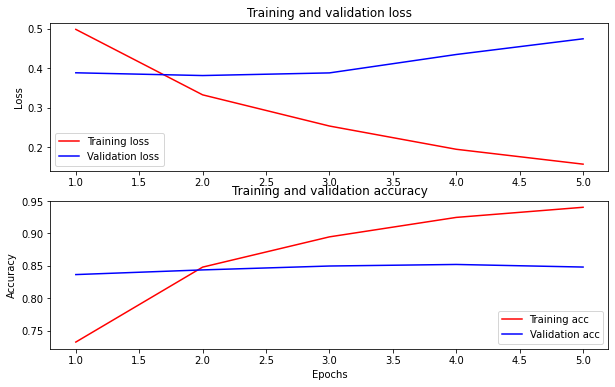

In [18]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [19]:
dataset_name = 'imdb'
saved_model_path = './{}_smallbert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)